# TRADING ENVIRONMENT POC
✅ Simple
✅ Deterministic
✅ Motivates switching between Buy / Sell / Hold
✅ Enables scoring against oracle and anti-oracle
✅ Built using a custom gym.Env class

## Design: Custom Trading Environment (Minimal)

### State
We simulate a predefined price series (e.g. up/down pattern):


* price_series = [1, 1.1, 1.2, 1.1, 1.0, 0.9, 1.0, 1.1, 1.2, 1.3]
## Actions
We will use position-as-action, because:

* It aligns with the vision: “teach the agent to know when to switch”
* Makes learning easier — every action is meaningful

We can always extend to finer-grained actions later

**Constraints**
* Agent can hold at most 1 share
* Must explicitly buy before profit, sell to realize
* Reward = change in portfolio value

## Rewards
**Oracle & Anti-Oracle**

Using the same price series:

* Oracle = best possible profit using allowed actions
* Anti-oracle = worst possible result from agent-like logic
* Agent = follows RecurrentPPO (later), random or hand-coded (now)

## Proposed Reward Function
**LONG**: reward = price[t+1] - price[t]
**FLAT** (not holding): reward = -(price[t+1] - price[t])
So the reward is always tied to market direction, but:

* Positive if agent is aligned

* Negative if agent is not

### Why This might work
**Dense rewards**
– The agent gets feedback every timestep, not only when it sells.
– This accelerates learning dramatically.

**Directional awareness**
– Agent must learn when to flip position to match price direction.

**No incentive to “do nothing”**
– Holding cash is not a neutral action anymore — it's wrong if the market trends up.

**Encourages timing and trend detection**
– Agent gets penalized if it stays flat during a rise, or long during a fall.



In [1]:
import jupyter

In [2]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from src.utils.system import boot
from src.data.feature_pipeline import load_base_dataframe
from experiments import check_if_experiment_exists, register_experiment ,experiment_hash

# ========== SYSTEM BOOT ==========
DEVICE = boot()
EXPERIMENT_NAME = "core_rl_trading_environment"
DEFAULT_PATH = "/data/experiments/" + EXPERIMENT_NAME


# ========== CONFIG ==========
CONFIG = {
    "ticker": "AAPL",
    "start_date": "2023-01-01",
    "end_date": "2024-01-01",
    "window_length_days": 60,
    "step_size_days": 30,
    "reward_type": "path_score",
    "model_save_path": DEFAULT_PATH + "/models",
    "log_path": DEFAULT_PATH + "/logs",
    "result_path": DEFAULT_PATH + "/results"
}
config_hash = experiment_hash(CONFIG)
exists = check_if_experiment_exists(config_hash)
DEVICE = boot()




OHLCV_DF = load_base_dataframe()

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
from datetime import datetime

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv



## Base Agent
* if price goes up and agent is holding, his reward = % price up / max_ep_reward
* Best possible score = 1
* Worst = 0


In [22]:
import gymnasium as gym
import numpy as np

import gymnasium as gym
import numpy as np
import pandas as pd
from datetime import timedelta

class PositionTradingEnv(gym.Env):
    def __init__(
        self,
        full_df: pd.DataFrame,
        ticker: str,
        n_timesteps: int = 60,
        lookback: int = 0,
        seed: int = 42,
    ):
        super().__init__()
        self.full_df = full_df.copy()
        self.ticker = ticker
        self.n_timesteps = n_timesteps
        self.lookback = lookback
        self.random_state = np.random.RandomState(seed)
        self.action_space = gym.spaces.Discrete(2)  # 0 = Flat, 1 = Long
        self.observation_space = gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)
        self.episode_df = None
        self.step_idx = 0
        self._prepare_ticker_df()
        self._resample_episode()

    def _prepare_ticker_df(self):
        self.df = self.full_df[self.full_df['symbol'] == self.ticker].copy()
        self.df = self.df.sort_values("date")
        self.df["date"] = pd.to_datetime(self.df["date"])
        self.df = self.df.reset_index(drop=True)

    def _resample_episode(self):
        mondays = self.df[self.df["date"].dt.weekday == 0].copy()
        valid_starts = []

        for date in mondays["date"]:
            start_idx = self.df.index[self.df["date"] == date][0]
            end_idx = start_idx + self.n_timesteps - 1
            if end_idx >= len(self.df):
                continue

            ep_slice = self.df.iloc[start_idx:end_idx + 1]
            if (ep_slice["symbol"].nunique() == 1) and (ep_slice["date"].is_monotonic_increasing):
                valid_starts.append(start_idx)

        if not valid_starts:
            raise ValueError("No valid episodes found with the current constraints.")

        self.start_idx = self.random_state.choice(valid_starts)
        self.end_idx = self.start_idx + self.n_timesteps - 1
        self.lookback_idx = max(0, self.start_idx - self.lookback)
        self.episode_df = self.df.iloc[self.lookback_idx:self.end_idx + 1].reset_index(drop=True)

        # Set prices used for reward logic
        self.prices = self.episode_df["close"].values
        self._precompute_step_weights()

    def _precompute_step_weights(self):
        raw_weights = [abs(self.prices[i + 1] - self.prices[i]) for i in range(len(self.prices) - 1)]
        total = sum(raw_weights)
        self.step_weights = [w / total if total > 0 else 1 / (len(raw_weights)) for w in raw_weights]

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self.random_state.seed(seed)
        self._resample_episode()
        self.step_idx = self.lookback
        self.position = 0
        self.total_reward = 0.0
        self.rewards = []
        self.actions = []
        self.values = []
        obs = np.array([self.prices[self.step_idx]], dtype=np.float32)
        return obs, {}

    def step(self, action):
        curr_idx = self.step_idx
        next_idx = min(curr_idx + 1, len(self.prices) - 1)
        curr_price = self.prices[curr_idx]
        next_price = self.prices[next_idx]
        price_diff = next_price - curr_price

        self.position = action
        agent_reward = price_diff if self.position == 1 else -price_diff
        oracle_reward = abs(price_diff)
        anti_reward = -oracle_reward

        if oracle_reward == anti_reward:
            step_score = 0.5
        else:
            step_score = (agent_reward - anti_reward) / (oracle_reward - anti_reward)

        step_score = float(np.clip(step_score, 0, 1))
        weight = self.step_weights[curr_idx - self.lookback] if curr_idx - self.lookback < len(self.step_weights) else 0
        scaled_reward = step_score * weight * 100

        self.total_reward += scaled_reward
        self.rewards.append(self.total_reward)
        self.actions.append(self.position)
        self.values.append(curr_price)

        self.step_idx += 1
        terminated = self.step_idx >= self.lookback + self.n_timesteps - 1
        truncated = False
        obs = np.array([self.prices[min(self.step_idx, len(self.prices) - 1)]], dtype=np.float32)

        return obs, scaled_reward, terminated, truncated, {}

import numpy as np
import matplotlib.pyplot as plt

# Use same price series as before
##price_series = [1, 1.05, 1.10, 1.08, 1.07, 1.12, 1.15, 1.13, 1.18, 1.20]

# Define the true oracle policy (best single entry/exit pair)
def true_oracle_policy(prices):
    best_start, best_end = 0, 0
    max_profit = 0
    for i in range(len(prices)):
        for j in range(i + 1, len(prices)):
            profit = prices[j] - prices[i]
            if profit > max_profit:
                max_profit = profit
                best_start, best_end = i, j
    actions = [0] * len(prices)
    for i in range(best_start, best_end):
        actions[i] = 1
    return actions

# Simulate using the action path
def simulate_from_action_path(prices, action_path):
    portfolio_value = [1.0]
    position = 0
    for i in range(1, len(prices)):
        action = action_path[i - 1]
        if action != position:
            position = action
        price_change = prices[i] - prices[i - 1]
        reward = price_change if position == 1 else -price_change
        portfolio_value.append(portfolio_value[-1] + reward)
    return portfolio_value


# Simulate anti-oracle: worst period to be long
def anti_oracle_policy(prices):
    worst_start, worst_end = 0, 0
    max_loss = 0
    for i in range(len(prices)):
        for j in range(i + 1, len(prices)):
            loss = prices[j] - prices[i]
            if loss < max_loss:
                max_loss = loss
                worst_start, worst_end = i, j
    actions = [0] * len(prices)
    for i in range(worst_start, worst_end):
        actions[i] = 1
    return actions

def score_episode(agent_ret, oracle_ret, anti_ret):
    if oracle_ret == anti_ret:
        return 50
    return float(np.clip(100 * (agent_ret - anti_ret) / (oracle_ret - anti_ret), 0, 100))


In [27]:
df_raw = OHLCV_DF.copy() #[OHLCV_DF['symbol'] ==CONFIG['ticker']]
df_raw = df_raw[(df_raw['date'] >=CONFIG['start_date']) & (df_raw['date']<CONFIG['end_date'])]
df_raw.set_index('date',inplace=True)
df_raw.head(3)

,id,symbol,timestamp,open,high,low,close,volume,trade_count,vwap,...,vwap_change,trade_count_change,sector_id,industry_id,return_1d,vix,vix_norm,sp500,sp500_norm,market_return_1d
date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,251,MMM,2023-01-03 05:00:00,121.52,122.635,120.37,122.47,2612812.0,44229.0,121.846135,...,0.019225,0.212484,8.0,unknown,0.021264,0.2290,0.056760,38.2414,-0.004001,-0.004001
2023-01-04,252,MMM,2023-01-04 05:00:00,123.35,125.290,122.71,125.15,2769831.0,46771.0,124.584773,...,0.022476,0.057474,8.0,unknown,0.021883,0.2201,-0.038865,38.5297,0.007539,0.007539
2023-01-05,253,MMM,2023-01-05 05:00:00,124.21,124.570,122.46,122.96,2606564.0,41426.0,123.168428,...,-0.011369,-0.114280,8.0,unknown,-0.017499,0.2246,0.020445,38.0810,-0.011646,-0.011646


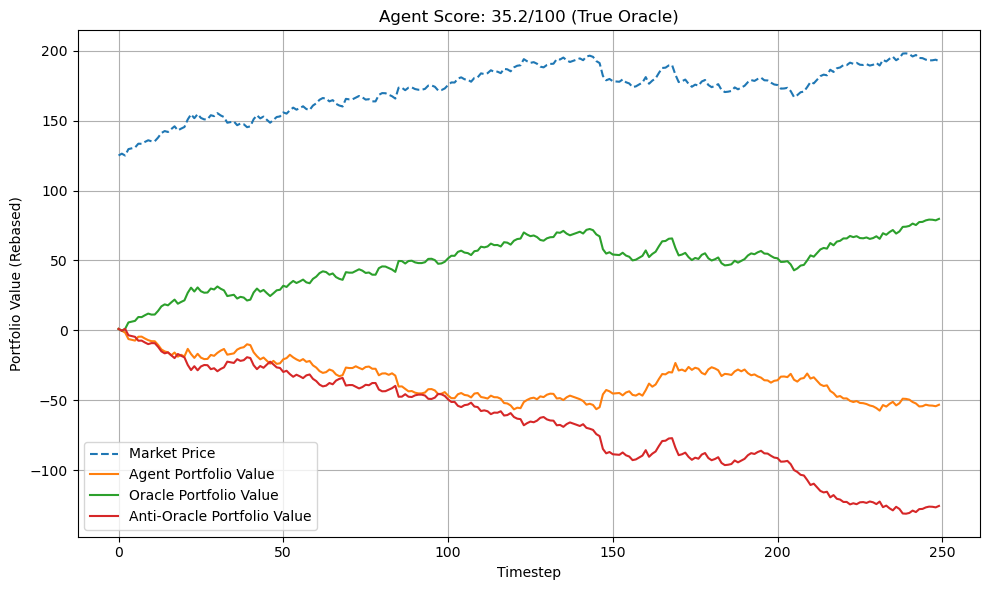

In [24]:
price_series = df_raw[['close']].values.flatten()

# Apply true oracle
oracle_actions = true_oracle_policy(price_series)
oracle_curve = simulate_from_action_path(price_series, oracle_actions)



anti_actions = anti_oracle_policy(price_series)
anti_curve = simulate_from_action_path(price_series, anti_actions)

# Simulate random agent
np.random.seed(42)
random_actions = np.random.choice([0, 1], size=len(price_series))
agent_curve = simulate_from_action_path(price_series, random_actions)

# Score agent
agent_ret = agent_curve[-1] - agent_curve[0]
oracle_ret = oracle_curve[-1] - oracle_curve[0]
anti_ret = anti_curve[-1] - anti_curve[0]



score = score_episode(agent_ret, oracle_ret, anti_ret)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(price_series, label="Market Price", linestyle='--')
plt.plot(agent_curve, label="Agent Portfolio Value")
plt.plot(oracle_curve, label="Oracle Portfolio Value")
plt.plot(anti_curve, label="Anti-Oracle Portfolio Value")
plt.title(f"Agent Score: {score:.1f}/100 (True Oracle)")
plt.xlabel("Timestep")
plt.ylabel("Portfolio Value (Rebased)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from gym import Env


def evaluate_agent(model, price_series, episodes=30):
    results = []
    for _ in range(episodes):
        env = PositionTradingEnv(price_series)
        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
        results.append(env.total_reward)  # ← correct 0–100 episode score
    return results  

def compare_vs_random(model, price_series, episodes=30):
    ppo_scores = evaluate_agent(model, price_series, episodes)
    
    random_scores = []
    for _ in range(episodes):
        env = PositionTradingEnv(price_series)
        obs, _ = env.reset()
        done = False
        while not done:
            action = env.action_space.sample()
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
        random_scores.append(env.total_reward)
    
    from scipy.stats import ttest_ind
    t_stat, p_val = ttest_ind(ppo_scores, random_scores, equal_var=False)

    return {
        "ppo_mean": np.mean(ppo_scores),
        "random_mean": np.mean(random_scores),
        "t_stat": t_stat,
        "p_val": p_val,
        "ppo_scores": ppo_scores,
        "random_scores": random_scores
    } 

# ---- Evaluation Pipeline ----
def run_learning_evaluation(prices, timesteps=10_000, eval_episodes=30, seed=42):
    np.random.seed(seed)

    # PPO Training
    env = Monitor(PositionTradingEnv(prices))
    model = PPO("MlpPolicy", env, verbose=1, seed=seed)
    model.learn(total_timesteps=timesteps)

    # PPO Evaluation
    eval_env = PositionTradingEnv(raw,'AAPL')
    _, ppo_rewards = evaluate_policy(model, eval_env, n_eval_episodes=eval_episodes, return_episode_rewards=True)

    # Random Evaluation
    def random_policy(env):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = env.action_space.sample()
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
        return total_reward

    random_scores = []
    for _ in range(eval_episodes):
        random_env = PositionTradingEnv(prices)
        random_scores.append(random_policy(random_env))
    """
    # Stats and Plot
    plt.figure(figsize=(10, 5))
    sns.histplot(ppo_scores, bins=20, label="PPO", color="green")  # kde=False by default
    sns.histplot(random_scores, bins=20, label="Random", color="red")
    plt.title("PPO vs Random Agent Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    """
    t_stat, p_val = ttest_ind(ppo_rewards, random_scores, equal_var=False)

    summary = {
        "ppo_mean": np.mean(ppo_rewards),
        "random_mean": np.mean(random_scores),
        "t_stat": t_stat,
        "p_val": p_val,
        "ppo_scores": ppo_rewards,
        "random_scores": random_scores
    }

    return summary, model,env

# --- Simulated test series ---
test_prices= np.cumsum(np.random.normal(loc=0.1, scale=0.2, size=120)) + 100
result_summary = run_learning_evaluation(test_prices)
result_summary


TypeError: PositionTradingEnv.__init__() missing 1 required positional argument: 'ticker'

In [26]:
ppo_rewards

[119, 119, 119]

In [15]:
# Re-run after kernel reset

import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
import gymnasium as gym

# Simulated price series
np.random.seed(42)
price_series = np.cumsum(np.random.normal(loc=0.1, scale=0.2, size=120)) + 100

# Define PositionTradingEnv
import gymnasium as gym
import numpy as np
import pandas as pd
from datetime import timedelta

class PositionTradingEnv(gym.Env):
    def __init__(
        self,
        full_df: pd.DataFrame,
        ticker: str,
        n_timesteps: int = 60,
        lookback: int = 0,
        seed: int = 42,
    ):
        super().__init__()
        self.full_df = full_df.copy()
        self.ticker = ticker
        self.n_timesteps = n_timesteps
        self.lookback = lookback
        self.random_state = np.random.RandomState(seed)
        self.action_space = gym.spaces.Discrete(2)  # 0 = Flat, 1 = Long
        self.observation_space = gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)
        self.episode_df = None
        self.step_idx = 0
        self._prepare_ticker_df()
        self._resample_episode()

    def _prepare_ticker_df(self):
        self.df = self.full_df[self.full_df['symbol'] == self.ticker].copy()
        self.df = self.df.sort_values("date")
        self.df["date"] = pd.to_datetime(self.df["date"])
        self.df = self.df.reset_index(drop=True)

    def _resample_episode(self):
        mondays = self.df[self.df["date"].dt.weekday == 0].copy()
        valid_starts = []

        for date in mondays["date"]:
            start_idx = self.df.index[self.df["date"] == date][0]
            end_idx = start_idx + self.n_timesteps - 1
            if end_idx >= len(self.df):
                continue

            ep_slice = self.df.iloc[start_idx:end_idx + 1]
            if (ep_slice["symbol"].nunique() == 1) and (ep_slice["date"].is_monotonic_increasing):
                valid_starts.append(start_idx)

        if not valid_starts:
            raise ValueError("No valid episodes found with the current constraints.")

        self.start_idx = self.random_state.choice(valid_starts)
        self.end_idx = self.start_idx + self.n_timesteps - 1
        self.lookback_idx = max(0, self.start_idx - self.lookback)
        self.episode_df = self.df.iloc[self.lookback_idx:self.end_idx + 1].reset_index(drop=True)

        # Set prices used for reward logic
        self.prices = self.episode_df["close"].values
        self._precompute_step_weights()

    def _precompute_step_weights(self):
        raw_weights = [abs(self.prices[i + 1] - self.prices[i]) for i in range(len(self.prices) - 1)]
        total = sum(raw_weights)
        self.step_weights = [w / total if total > 0 else 1 / (len(raw_weights)) for w in raw_weights]

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self.random_state.seed(seed)
        self._resample_episode()
        self.step_idx = self.lookback
        self.position = 0
        self.total_reward = 0.0
        self.rewards = []
        self.actions = []
        self.values = []
        obs = np.array([self.prices[self.step_idx]], dtype=np.float32)
        return obs, {}

    def step(self, action):
        curr_idx = self.step_idx
        next_idx = min(curr_idx + 1, len(self.prices) - 1)
        curr_price = self.prices[curr_idx]
        next_price = self.prices[next_idx]
        price_diff = next_price - curr_price

        self.position = action
        agent_reward = price_diff if self.position == 1 else -price_diff
        oracle_reward = abs(price_diff)
        anti_reward = -oracle_reward

        if oracle_reward == anti_reward:
            step_score = 0.5
        else:
            step_score = (agent_reward - anti_reward) / (oracle_reward - anti_reward)

        step_score = float(np.clip(step_score, 0, 1))
        weight = self.step_weights[curr_idx - self.lookback] if curr_idx - self.lookback < len(self.step_weights) else 0
        scaled_reward = step_score * weight * 100

        self.total_reward += scaled_reward
        self.rewards.append(self.total_reward)
        self.actions.append(self.position)
        self.values.append(curr_price)

        self.step_idx += 1
        terminated = self.step_idx >= self.lookback + self.n_timesteps - 1
        truncated = False
        obs = np.array([self.prices[min(self.step_idx, len(self.prices) - 1)]], dtype=np.float32)

        return obs, scaled_reward, terminated, truncated, {}


# Create and wrap environment
env = Monitor(PositionTradingEnv(price_series))

# Train PPO model
model = PPO("MlpPolicy", env, verbose=0, seed=42)
model.learn(total_timesteps=5000)

# Evaluate PPO model
ppo_scores = []
for _ in range(3):
    eval_env = PositionTradingEnv(price_series)
    obs, _ = eval_env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = eval_env.step(action)
        done = terminated or truncated
        total_reward += reward
    ppo_scores.append(total_reward)

ppo_scores


[76.03475679750039, 76.03475679750039, 76.03475679750039]

In [20]:
# Force deterministic policy
mean_reward, ep_rewards = evaluate_policy(
    model,
    eval_env,
    n_eval_episodes=3,
    return_episode_rewards=True,
    deterministic=True
)

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [21]:
mean_reward,ep_rewards

([76.03475692309439, 76.03475692309439, 76.03475692309439], [119, 119, 119])